![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.Spark_OCR.ipynb)

# Spark OCR 

## Colab Setup

In [1]:
import json

with open('workshop_license_keys.json') as f_in:
    license_keys = json.load(f_in)

license_keys.keys()

dict_keys(['secret', 'SPARK_NLP_LICENSE', 'JSL_OCR_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'JSL_OCR_SECRET'])

In [ ]:
# template for license_key.json

{'secret':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"1.2.0-xxx"}

In [ ]:
# Attention: You need to run this cell twice due to some issue regarding Colab predefined settings

import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


os.environ['JSL_OCR_LICENSE'] = license_keys['JSL_OCR_LICENSE']

ocr_version = license_keys['JSL_OCR_SECRET'].split('-')[0]

secret = license_keys['JSL_OCR_SECRET']


# install Spark OCR
! pip install spark-ocr==$ocr_version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade


In [3]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import os

# start(secret=None, jar_path=None, extra_conf=None, nlp_version=None, nlp_internal=False):

spark = start(secret=secret)
spark

## OCR Pipelines

In [ ]:
!wget -q 'http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf'


In [ ]:
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel

def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()
    pdf_to_image.setInputCol("content")
    pdf_to_image.setOutputCol("image")

    # Run tesseract OCR
    ocr = TesseractOcr()
    ocr.setInputCol("image")
    ocr.setOutputCol("text")
    ocr.setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

In [ ]:
pdf = '43nyyw9r820c6r.pdf'
pdf_example_df = spark.read.format("binaryFile").load(pdf).cache()

In [ ]:
result = pipeline().transform(pdf_example_df).cache()


In [19]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|ASX ANNOUNCEMENT
...|95.18117046356201|
+-------+--------------------+-----------------+



In [20]:
result.select("text").collect()

[Row(text='ASX ANNOUNCEMENT\n3 November 2017\n\nNotice Pursuant to Paragraph 708A(5)(e) of the Corporations Act\n2001 ("Act")\n\nDigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today\nissued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted\nOptions exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon\nexercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February\n2018.\n\nThe Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt\nunder section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above\nwill fall within the exemption in section 708A(5) of the Act.\n\nThe Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:\n(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of\nthe Act;\n(b) as at the date of this notice, the Company has complied with the provisions of 

In [21]:
print("\n".join([row.text for row in result.select("text").collect()]))


ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they 

##  with skew correction

In [ ]:
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from sparkocr.utils import display_image
from sparkocr.metrics import score

In [ ]:
def ocr_pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()
    pdf_to_image.setInputCol("content")
    pdf_to_image.setOutputCol("image")

    # Image skew corrector 
    skew_corrector = ImageSkewCorrector()
    skew_corrector.setInputCol("image")
    skew_corrector.setOutputCol("corrected_image")
    skew_corrector.setAutomaticSkewCorrection(skew_correction)

    # Run tesseract OCR
    ocr = TesseractOcr()
    ocr.setInputCol("corrected_image")
    ocr.setOutputCol("text")
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline

In [ ]:
pdf_rotated_df = spark.read.format("binaryFile").load('/content/400_rot.pdf').cache()

In [ ]:
pdf_pipeline = ocr_pipeline(False) 

result = pdf_pipeline.transform(pdf_rotated_df).cache()

pdf_pipeline = ocr_pipeline(True) 

corrected_result = pdf_pipeline.transform(pdf_rotated_df).cache()

### Display recognized text without skew correction


In [10]:
result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|95.71951103210449|
+-------+--------------------+-----------------+



In [40]:
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know

that good little ideas make the good large design possible.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by

It is difficul

In [35]:
corrected_result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|95.61764068603516|
+-------+--------------------+-----------------+



### Display results with skew correction

In [42]:
corrected_result.select("pagenum","text", "confidence").show()


+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|FOREWORD

Electro...|95.61764068603516|
+-------+--------------------+-----------------+



In [41]:
print("\n".join([row.text for row in corrected_result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

Document: file:/content/400_rot.pdf
Page: 0
Image:
        origin: file:/content/400_rot.pdf 
        width: 2480
        height: 3507
        mode: 10


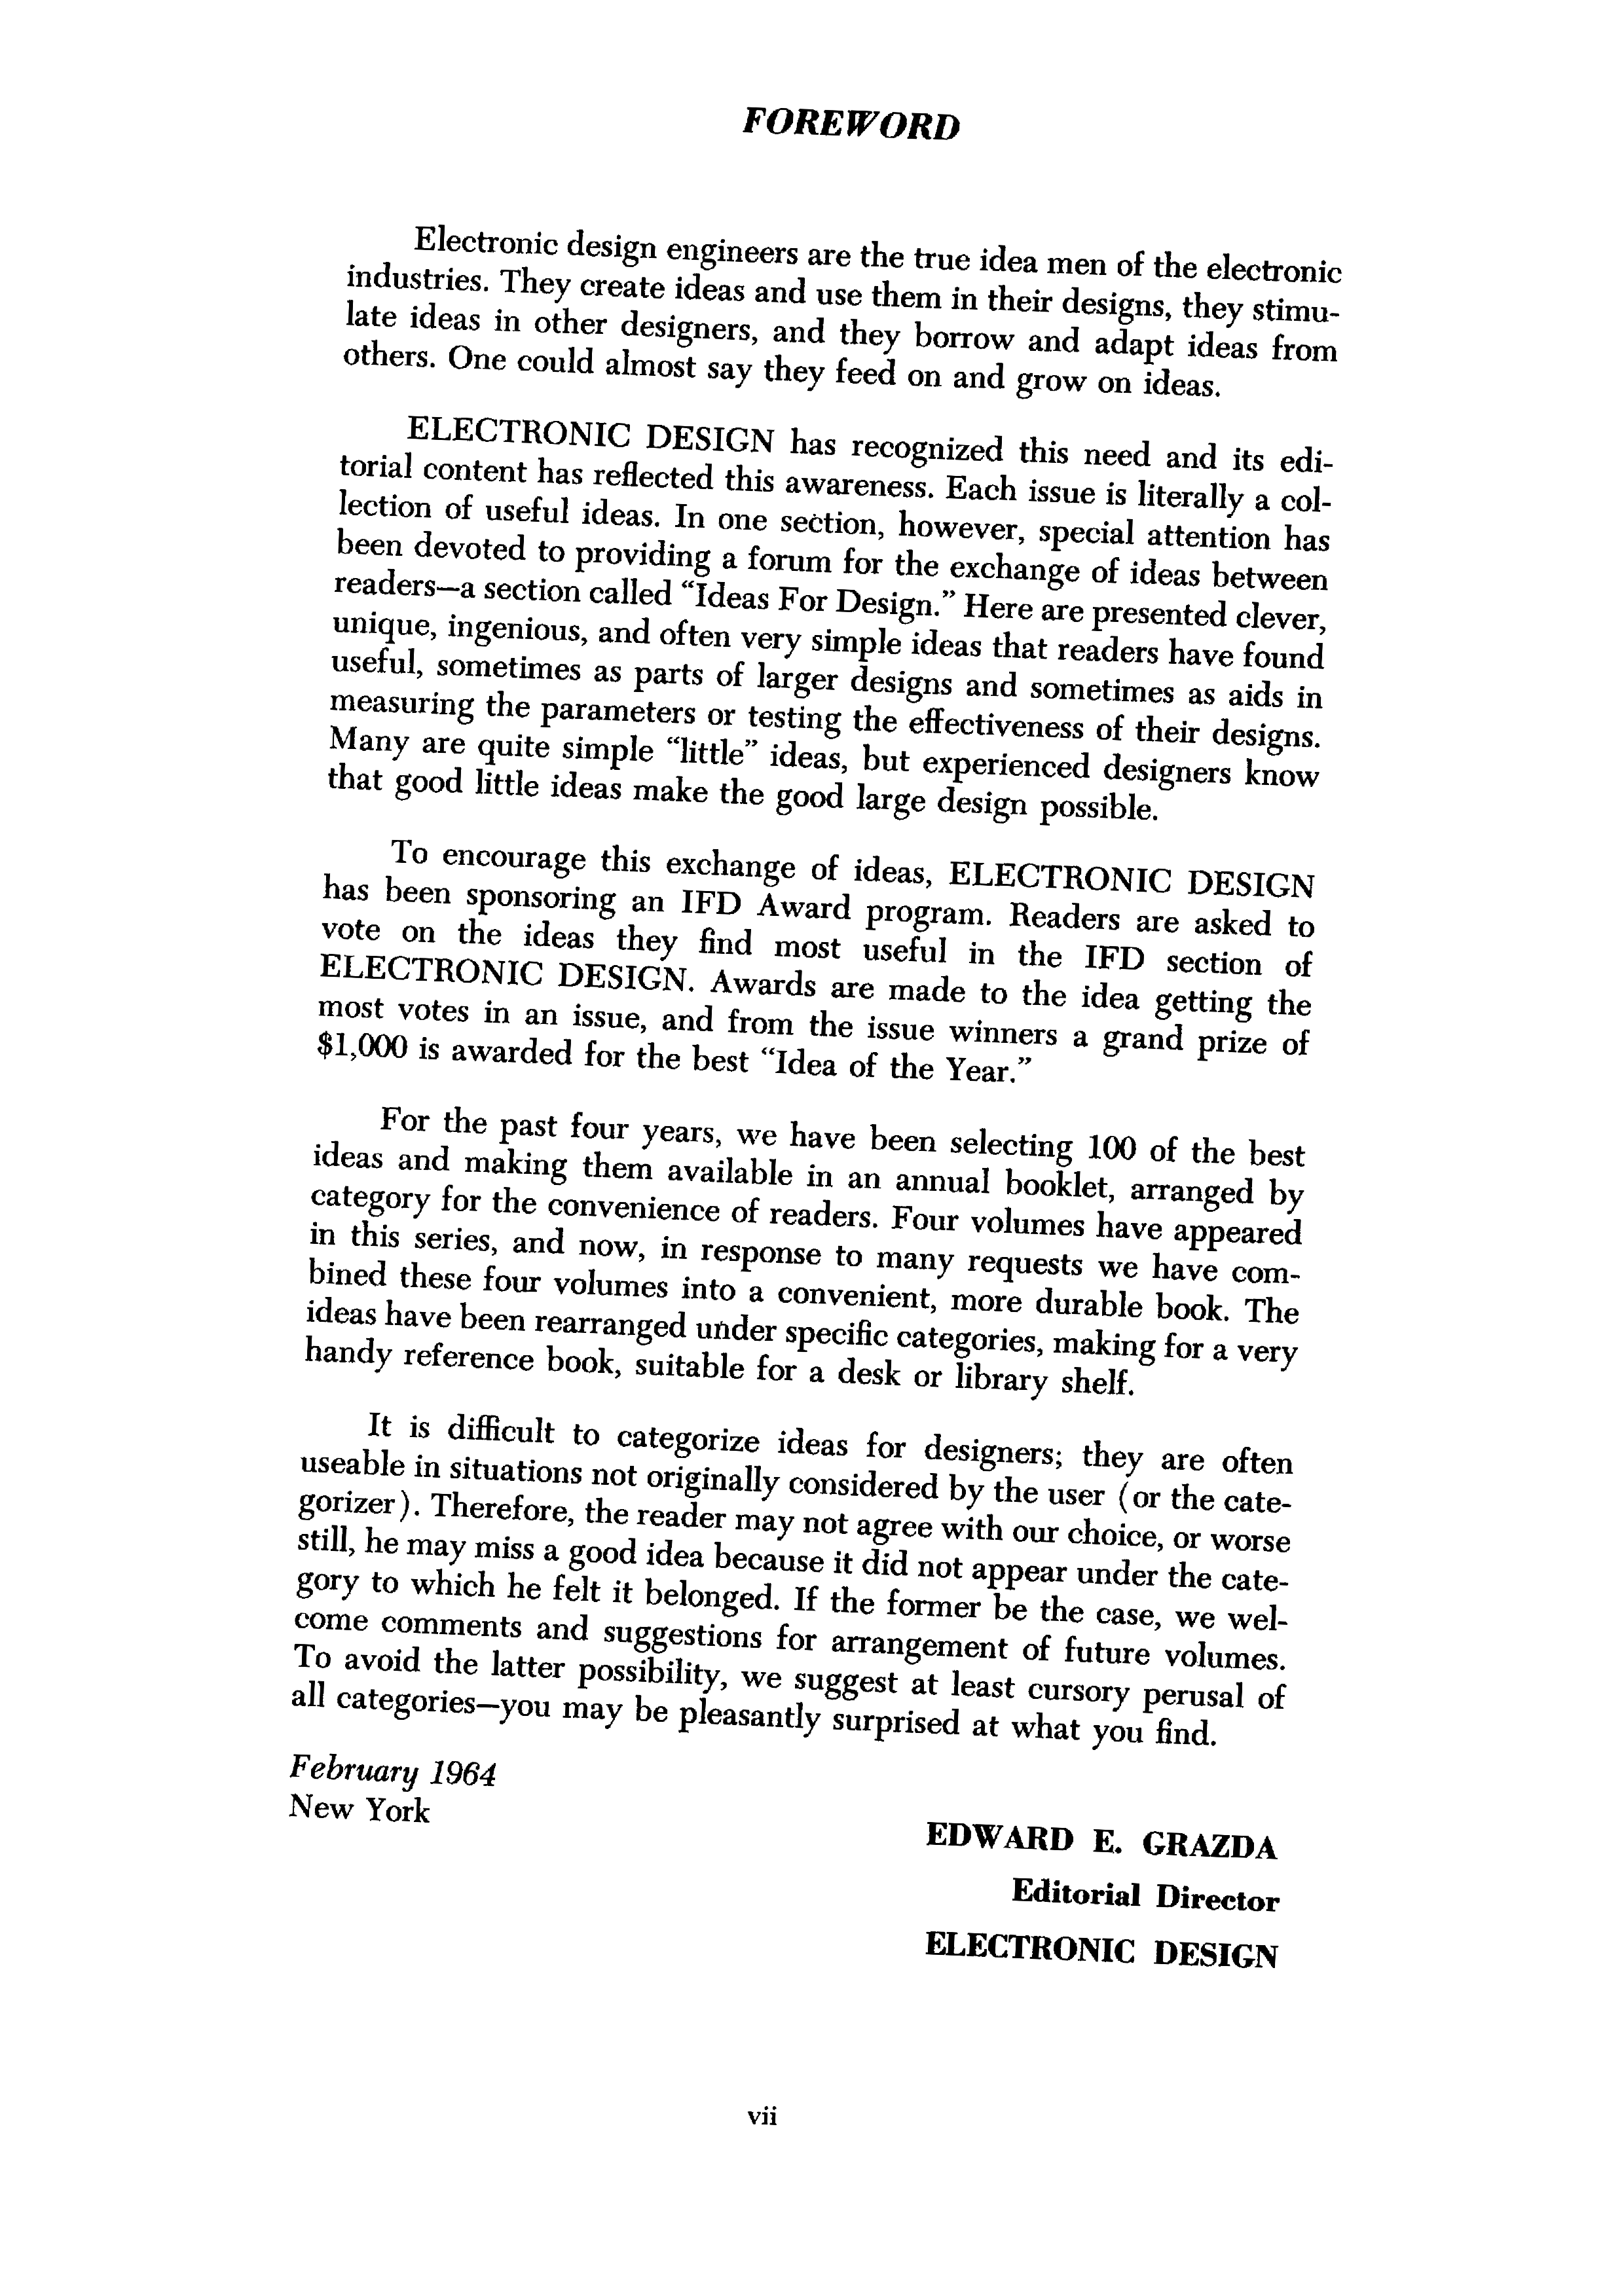

In [46]:
for r in result.select("path", "pagenum", "image").distinct().collect():
    print("Document: %s" % r.path)
    print("Page: %d" % r.pagenum)
    display_image(r.image)

### Display skew korrected images

Document: file:/content/400_rot.pdf
Page: 0
Image:
        origin: file:/content/400_rot.pdf 
        width: 2600
        height: 3591
        mode: 10


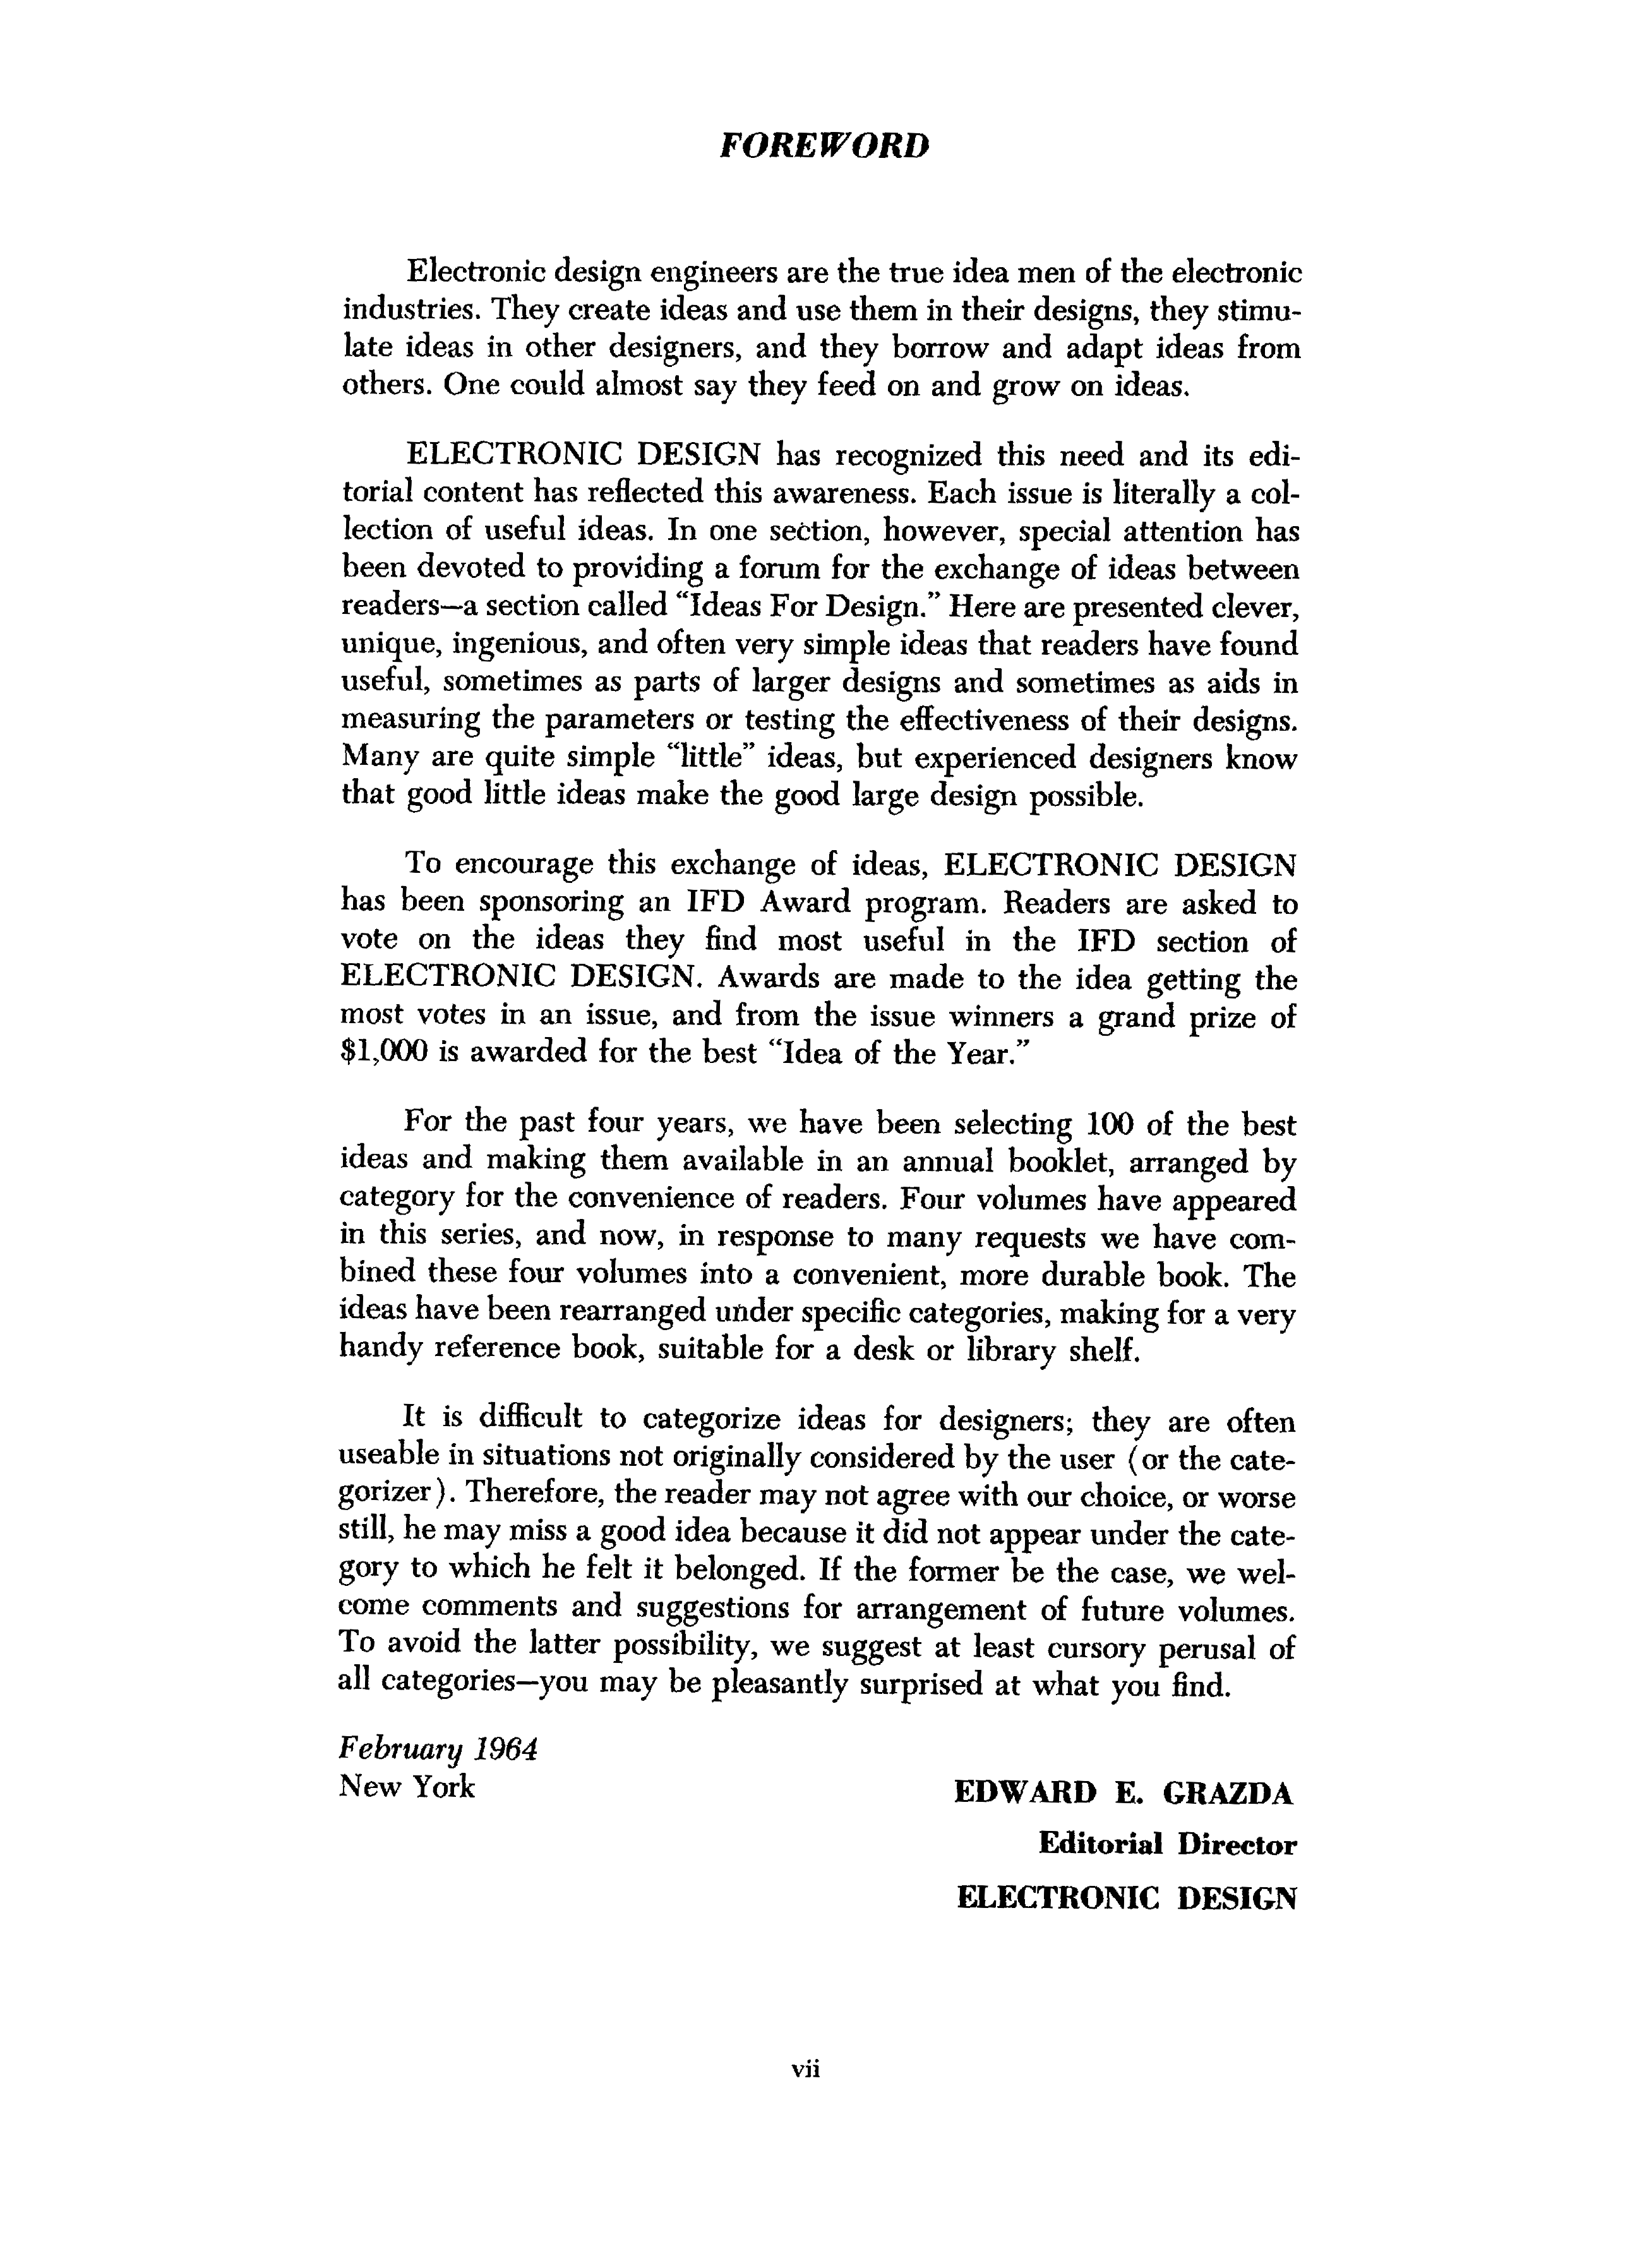

In [49]:

for r in corrected_result.select("path", "pagenum", "corrected_image").distinct().collect():
    print("Document: %s" % r.path)
    print("Page: %d" % r.pagenum)
    display_image(r.corrected_image)

## Compute score and compare
Read original text and calculate scores for both results.

In [45]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
pdf_rotated_text = open('400.txt', "r").read()

# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.7270361696591204
Score with skew correction: 0.9944501541623842


## Removing background noise




In [ ]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image
from sparkocr.metrics import score

In [ ]:
# Read binary as image
binary_to_image = BinaryToImage()\
  .setInputCol("content")\
  .setOutputCol("image")

# Scale image
scaler = ImageScaler()\
  .setInputCol("image")\
  .setOutputCol("scaled_image")\
  .setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()\
  .setInputCol("scaled_image")\
  .setOutputCol("binarized_image")\
  .setBlockSize(91)\
  .setOffset(60)

# Apply morphology opening
opening = ImageMorphologyOpening()\
  .setKernelShape(KernelShape.SQUARE)\
  .setKernelSize(2)\
  .setInputCol("binarized_image")\
  .setOutputCol("opening_image")

# Remove small objects
remove_objects = ImageRemoveObjects()\
  .setInputCol("opening_image")\
  .setOutputCol("corrected_image")\
  .setMinSizeFont(30)

# Run tesseract OCR for each region
ocr = TesseractOcr()\
  .setInputCol("corrected_image")\
  .setOutputCol("text")\
  .setConfidenceThreshold(75)\
  .setPageSegMode(PageSegmentationMode.SINGLE_BLOCK)\
  .setIgnoreResolution(False)

# Path to the tessdata related to the OS and version
# ocr.setTessdata("/usr/local/Cellar/tesseract-lang/4.0.0/share/tessdata")
# ocr.setLanguage("fra")


# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    opening,
    remove_objects,
    ocr
])

In [60]:
image_df = spark.read.format("binaryFile").load('noisy.png').cache()
image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/noi...|2020-05-11 22:25:43|413306|[89 50 4E 47 0D 0...|
+--------------------+-------------------+------+--------------------+



In [ ]:
result = pipeline.transform(image_df).cache()


In [62]:
result.select("text", "confidence").show()


+----+-----------------+
|text|       confidence|
+----+-----------------+
|    |71.97016143798828|
+----+-----------------+



Original: file:/content/noisy.png
Image:
        origin: file:/content/noisy.png 
        width: 1312
        height: 948
        mode: 10


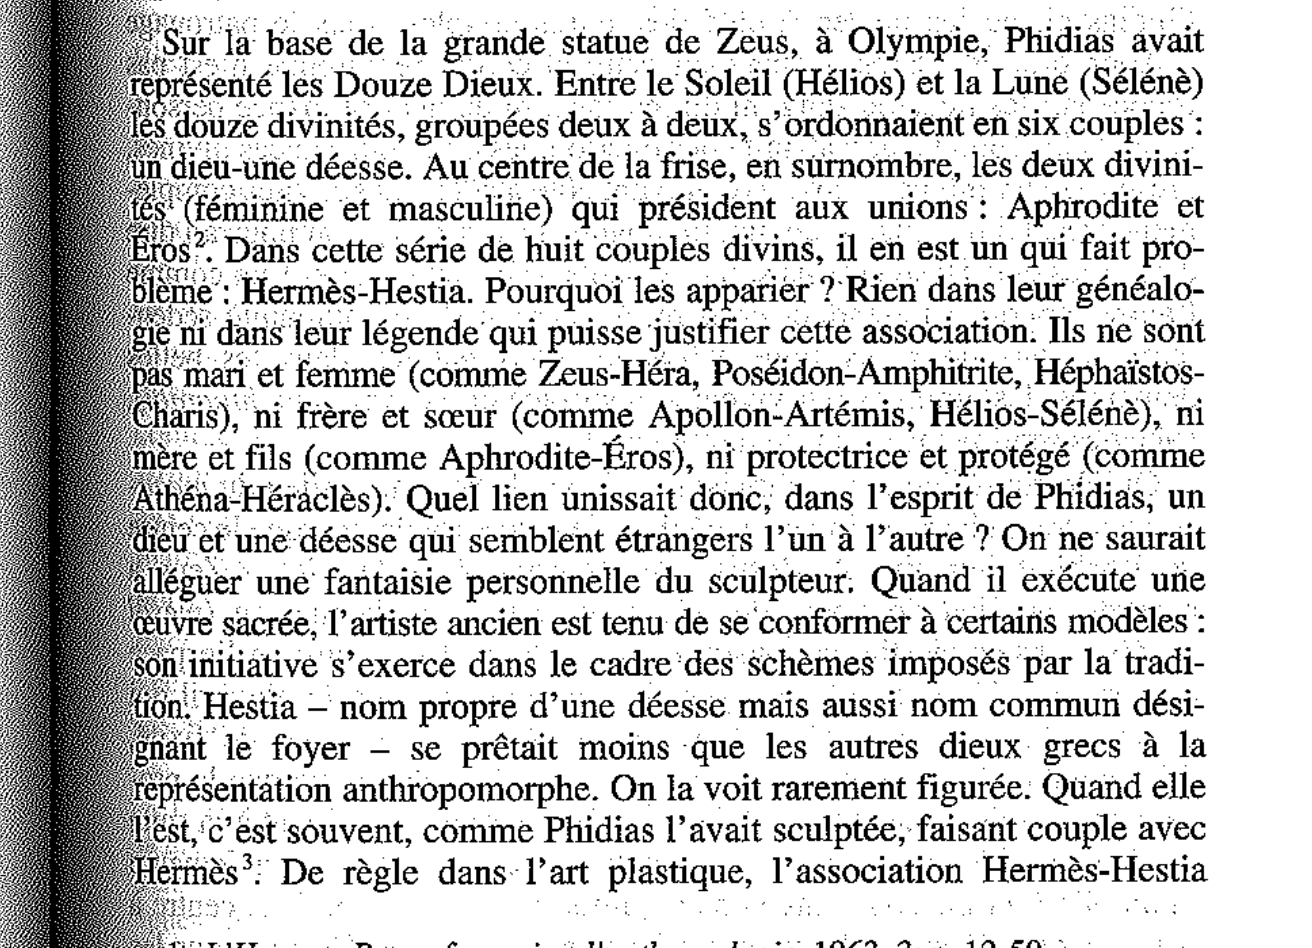

Binarized: file:/content/noisy.png
Image:
        origin: file:/content/noisy.png 
        width: 2624
        height: 1896
        mode: 10


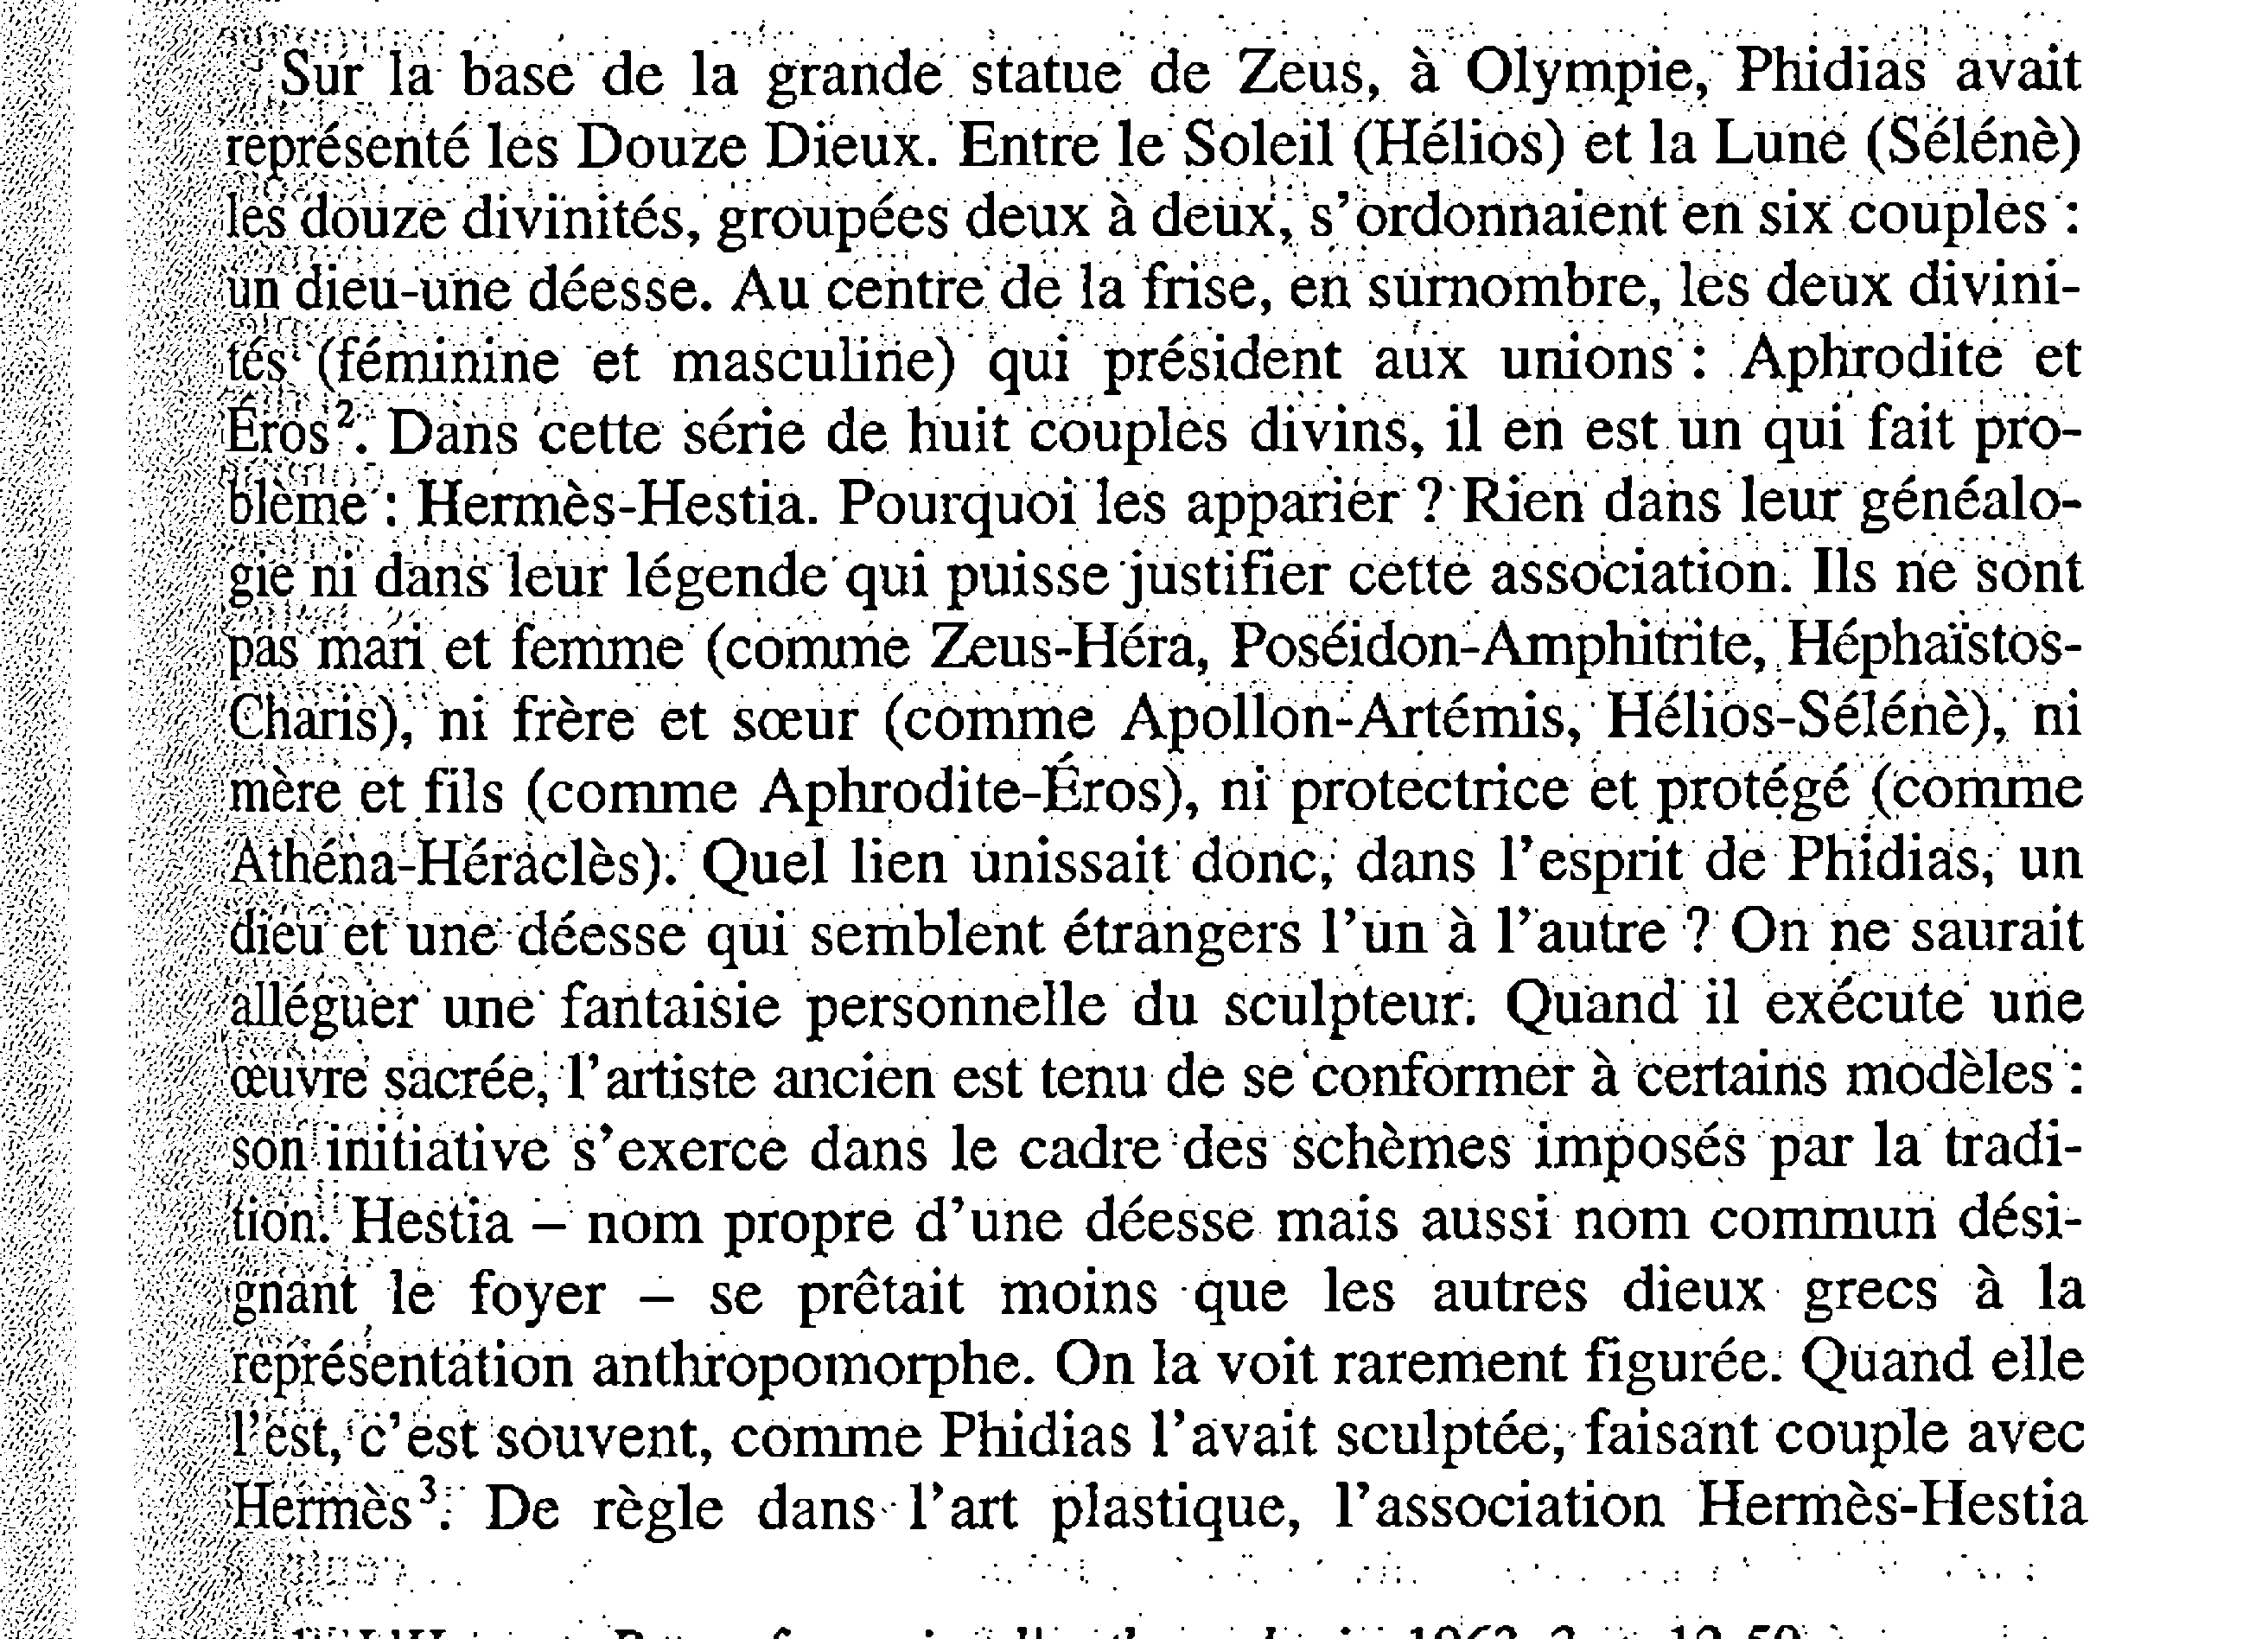

Morphology opening: file:/content/noisy.png
Image:
        origin: file:/content/noisy.png 
        width: 2624
        height: 1896
        mode: 10


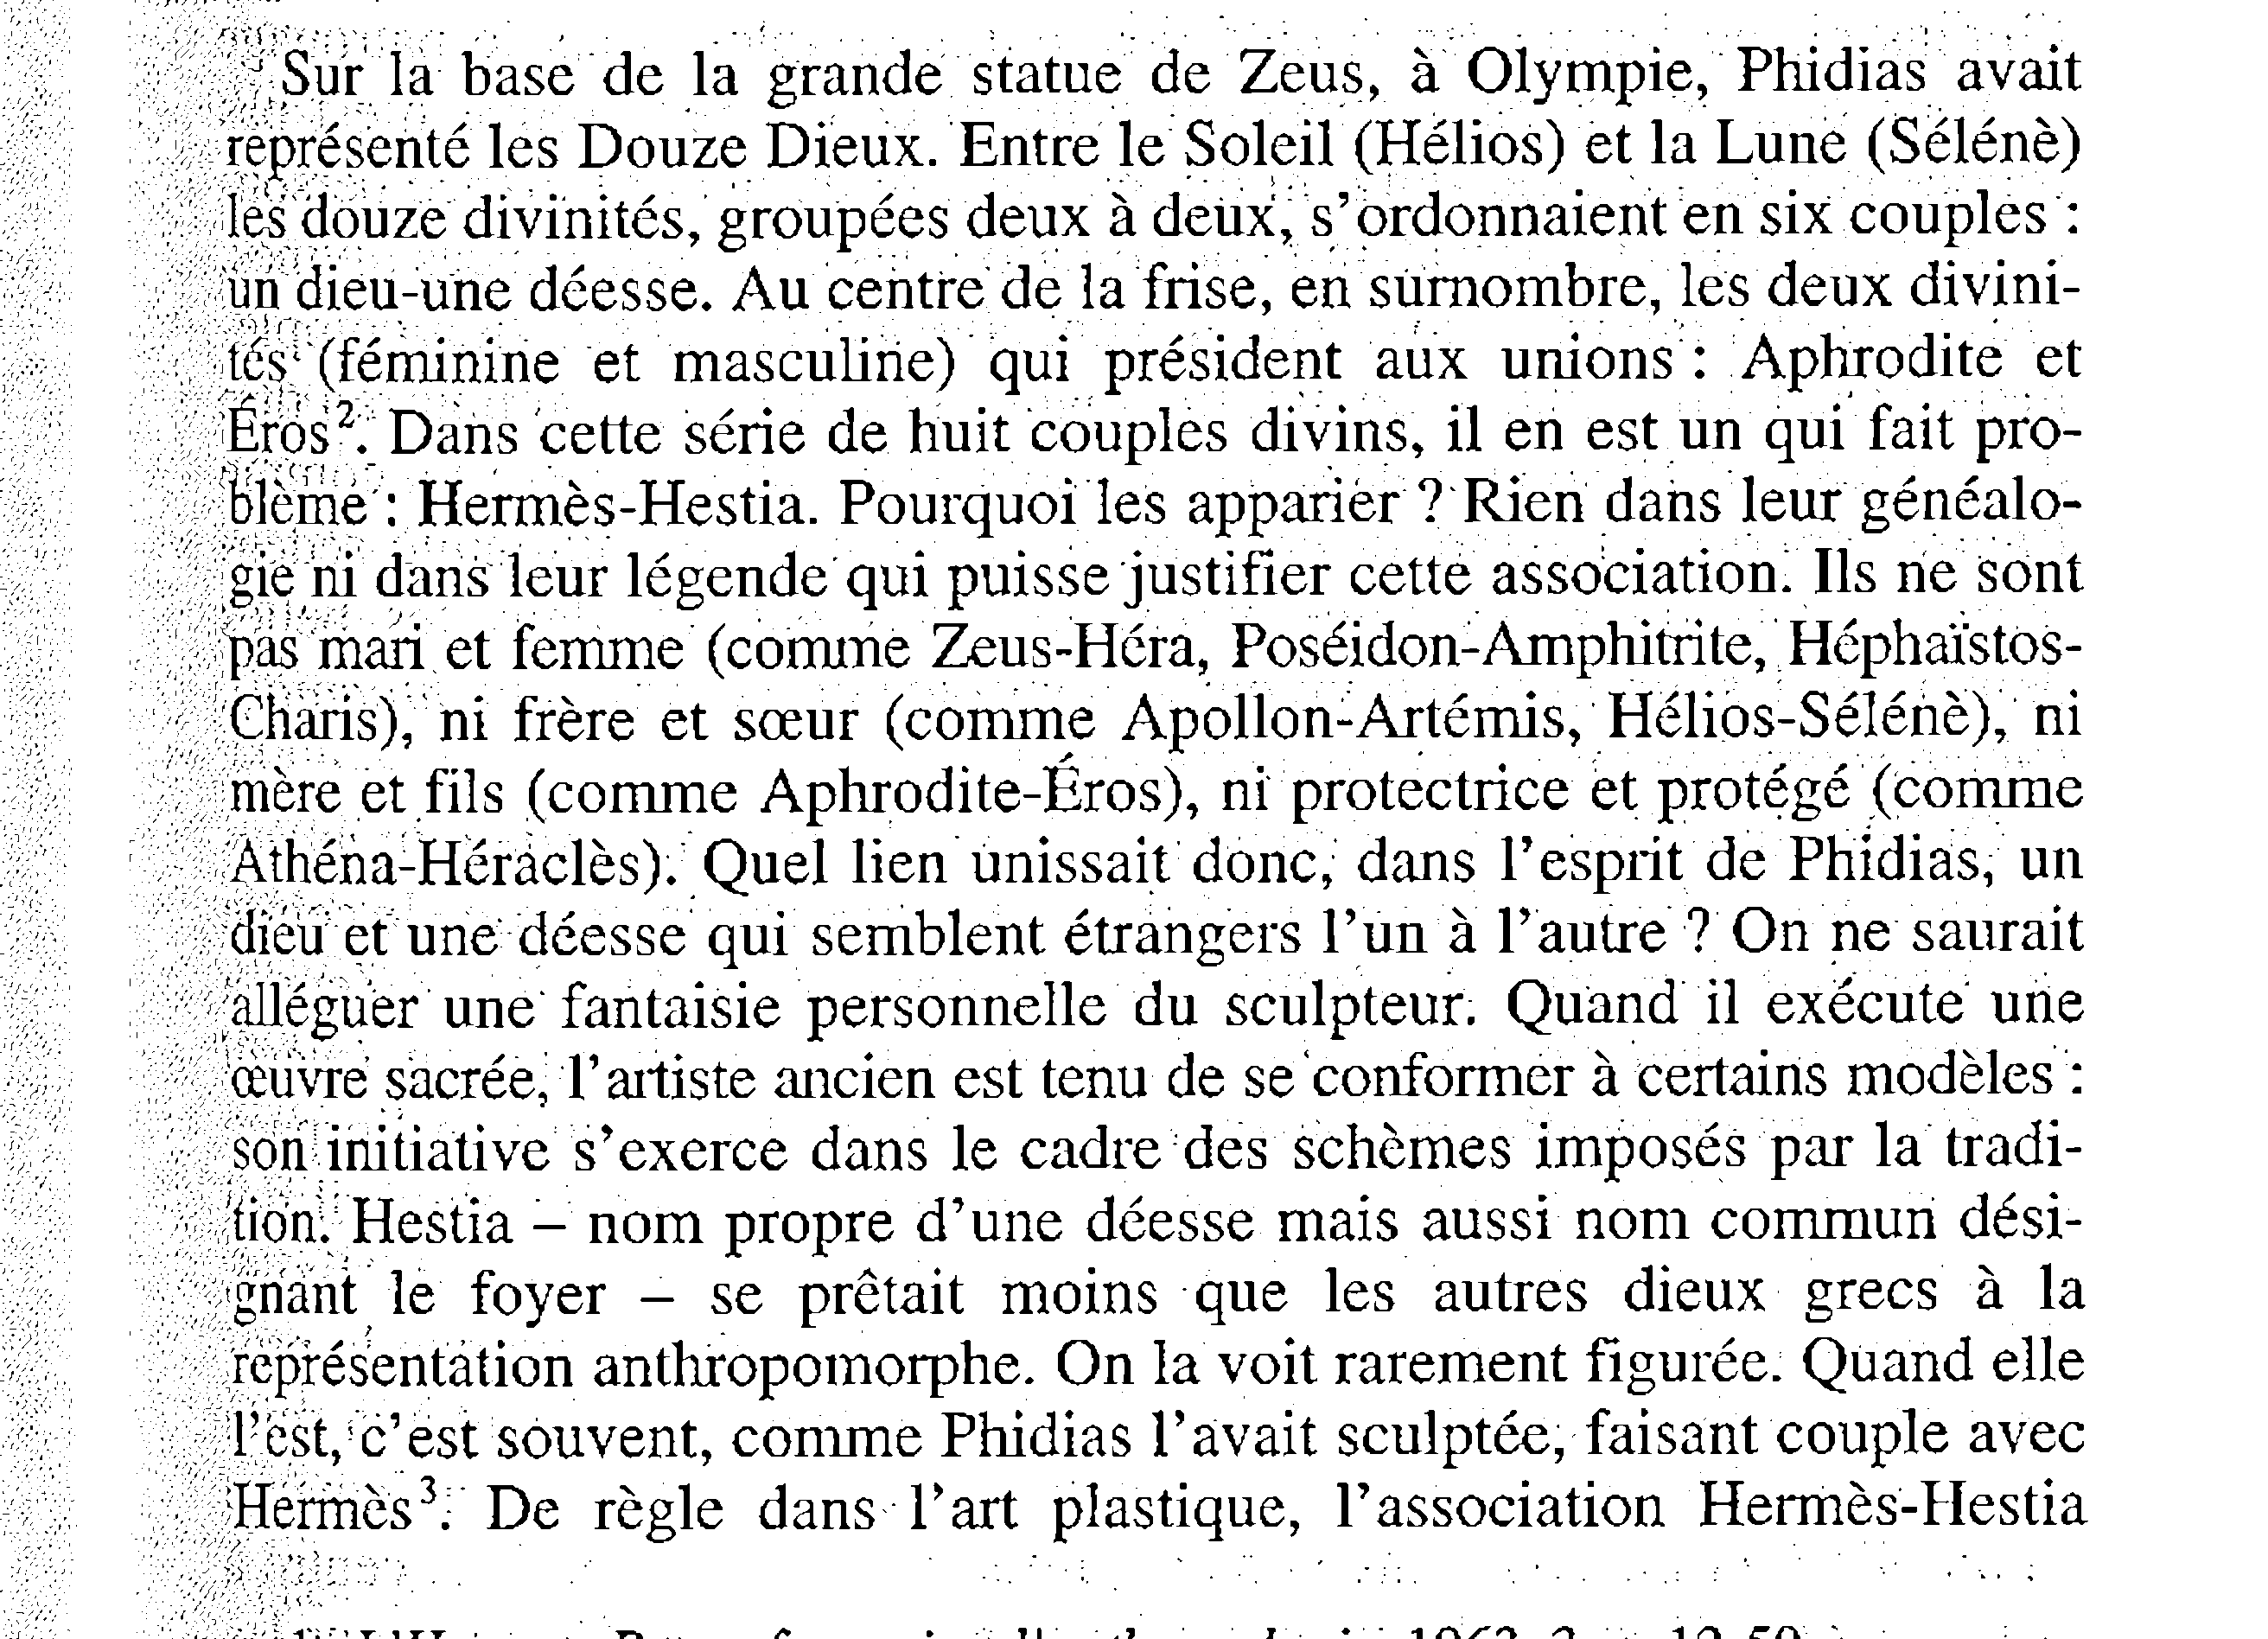

Remove small objects: file:/content/noisy.png
Image:
        origin: file:/content/noisy.png 
        width: 2624
        height: 1896
        mode: 10


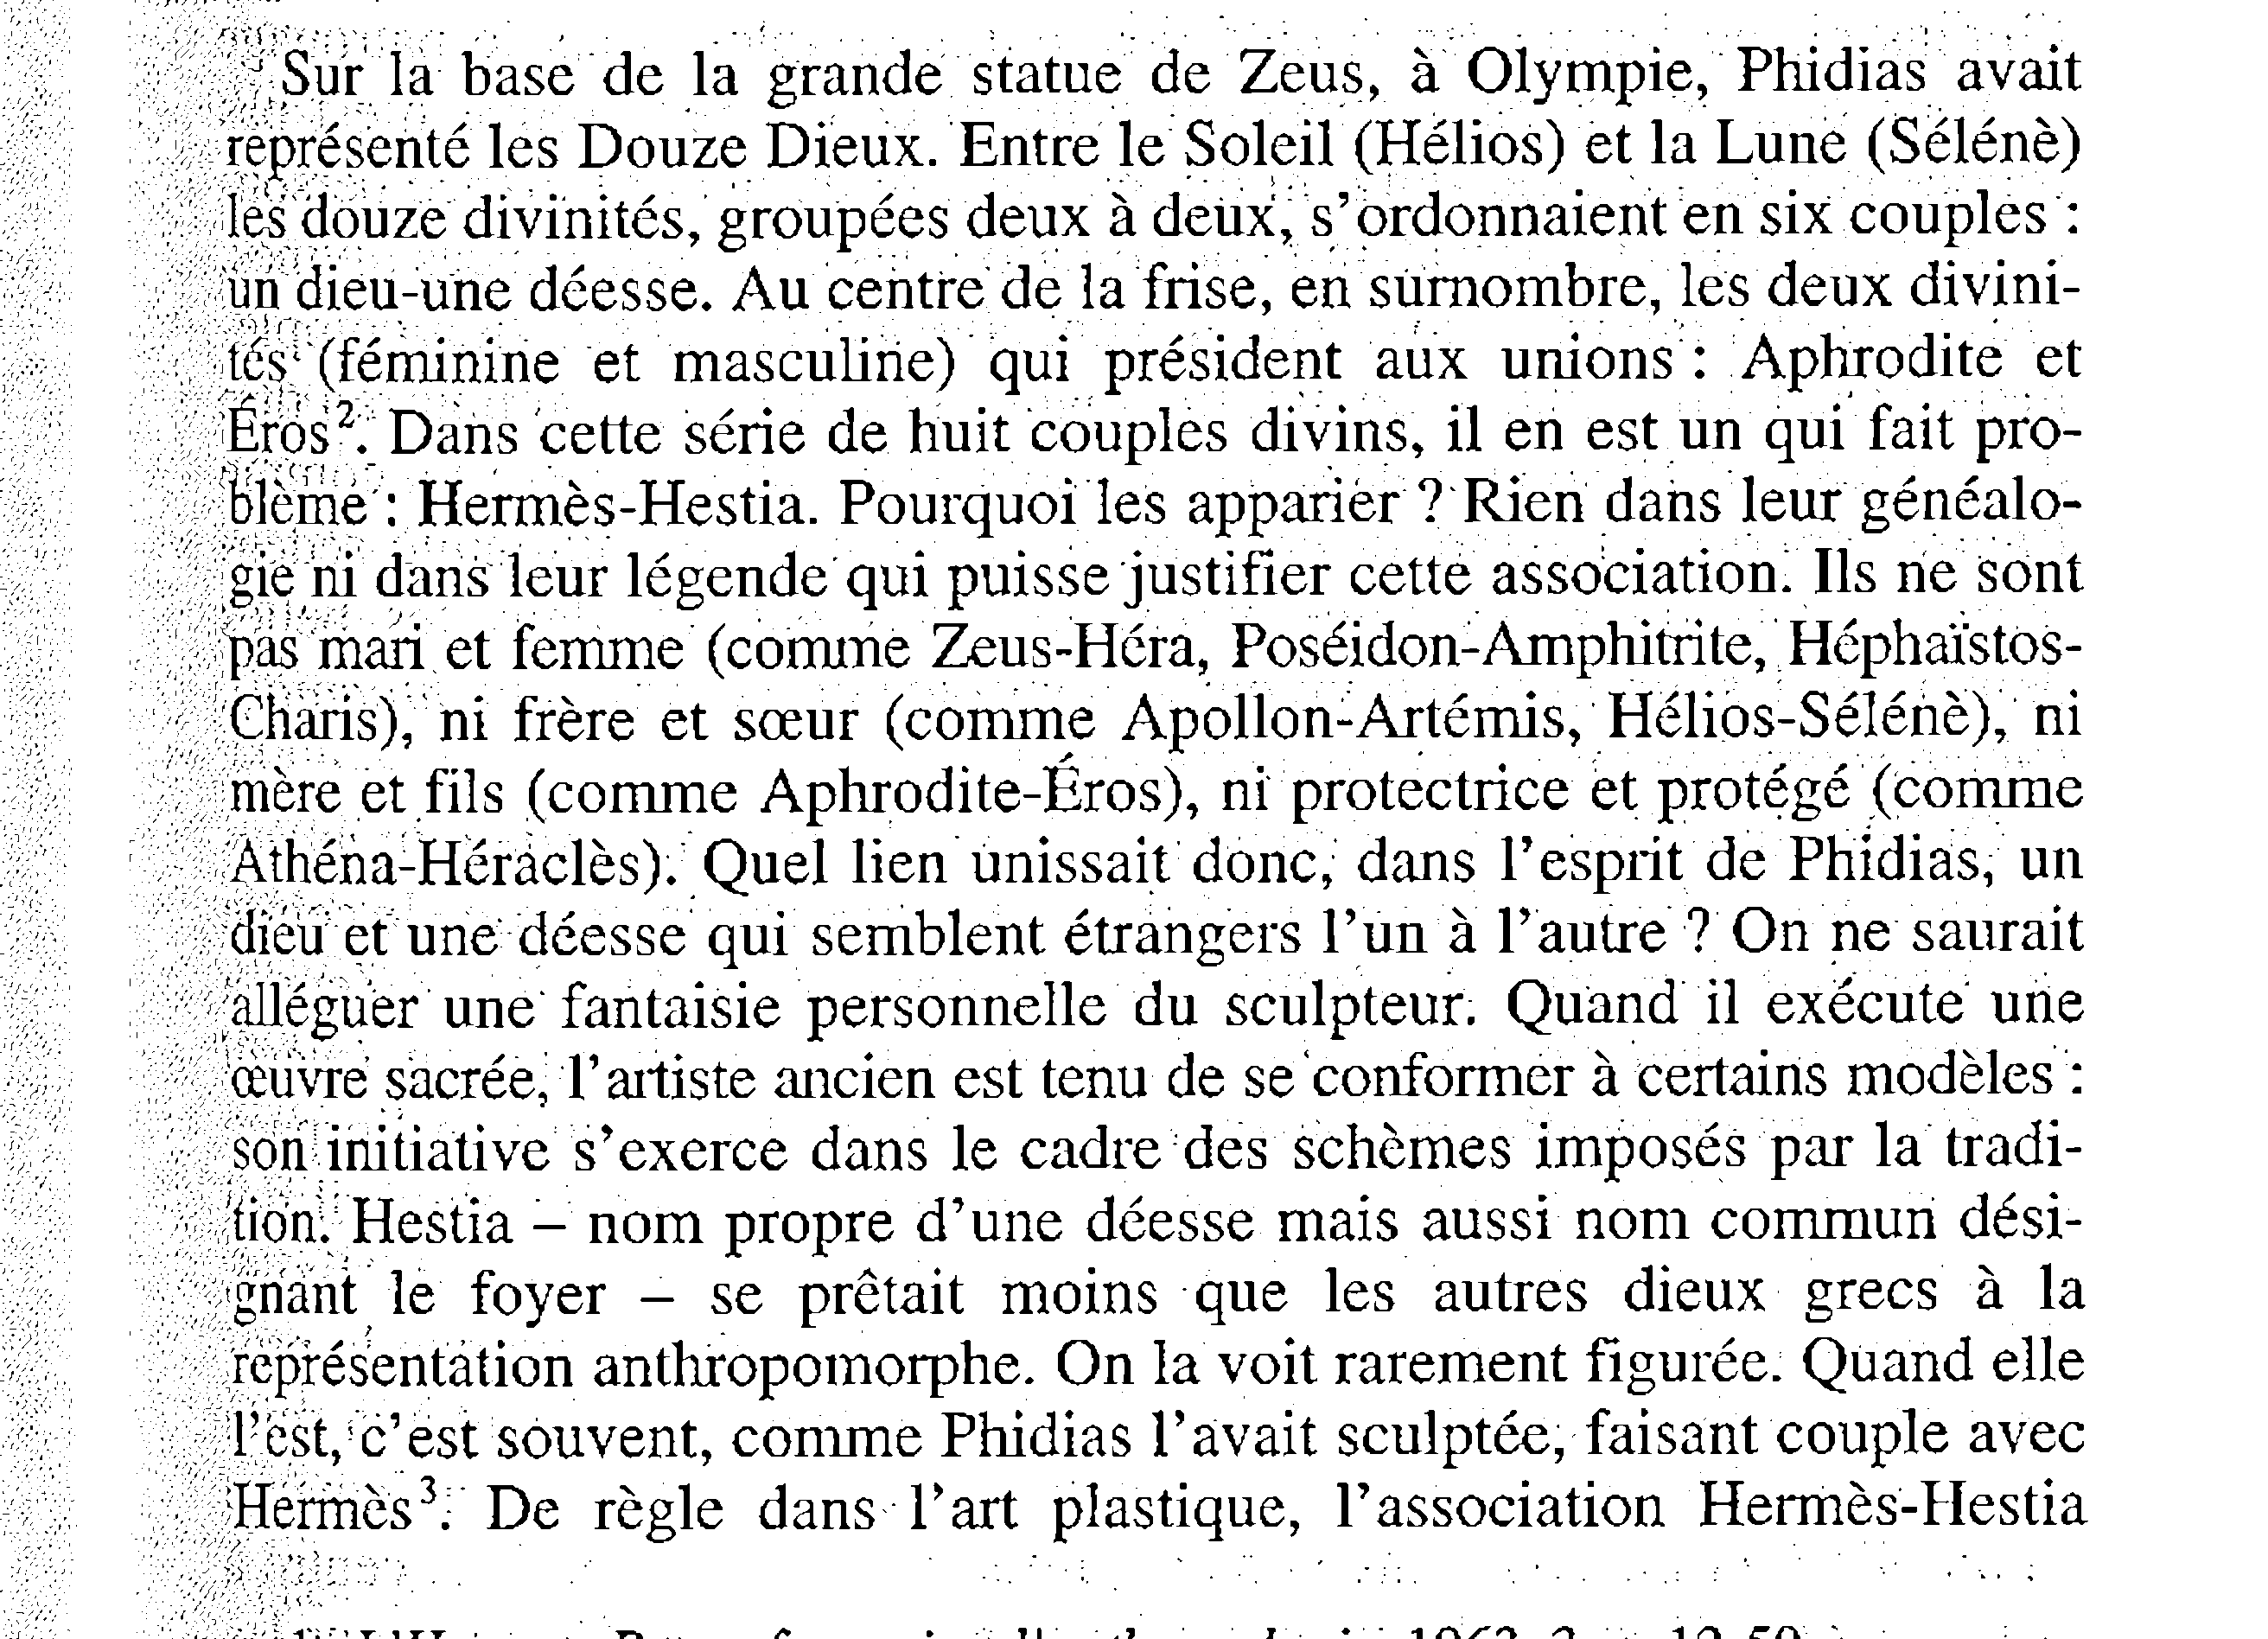

In [64]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized: %s" % r.path)
    display_image(r.binarized_image)
    print("Morphology opening: %s" % r.path)
    display_image(r.opening_image)
    print("Remove small objects: %s" % r.path)
    display_image(r.corrected_image)

## Image OCR

In [ ]:
! wget https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/grey_background.png
! wget https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/images/text_with_noise.png

In [ ]:
images_path = "/content/*.png"

images = spark.read.format("binaryFile").load(images_path).cache()
#images = spark.read.format("binaryFile").load('text_with_noise.png').cache()

images.count()

In [ ]:
# Transform binary to image
binary_to_image = BinaryToImage()\
  .setInputCol("content")\
  .setOutputCol("image")

# Run tesseract OCR for each region
ocr = TesseractOcr()\
  .setInputCol("image")\
  .setOutputCol("text")\
  .setIgnoreResolution(False)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [ ]:
results = pipeline.transform(images)


In [ ]:
results.show()

## More example here

https://github.com/JohnSnowLabs/spark-ocr-workshop